# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="images/human_values.png" alt="human values" />
</center>

In [48]:
!pip install transformers

In [49]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
from torch.nn import BCEWithLogitsLoss
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

In [50]:
!mkdir data
!curl https://zenodo.org/records/8248658/files/arguments-training.tsv?download=1 -o data/arguments-training.tsv
!curl https://zenodo.org/records/8248658/files/arguments-validation.tsv?download=1 -o data/arguments-validation.tsv
!curl https://zenodo.org/records/8248658/files/arguments-test.tsv?download=1 -o data/arguments-test.tsv
!curl https://zenodo.org/records/8248658/files/labels-training.tsv?download=1 -o data/labels-training.tsv
!curl https://zenodo.org/records/8248658/files/labels-validation.tsv?download=1 -o data/labels-validation.tsv
!curl https://zenodo.org/records/8248658/files/labels-test.tsv?download=1 -o data/labels-test.tsv

mkdir: cannot create directory ‘data’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  988k  100  988k    0     0   497k      0  0:00:01  0:00:01 --:--:--  496k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  354k  100  354k    0     0   185k      0  0:00:01  0:00:01 --:--:--  185k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  283k  100  283k    0     0   144k      0  0:00:01  0:00:01 --:--:--  144k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  247k  100  247k    0     0   129k      0  0:00:01  0:00:01 --:--:--  129k
 

In [51]:
arguments_train = pd.read_csv('data/arguments-training.tsv', sep='\t')
arguments_val = pd.read_csv('data/arguments-validation.tsv', sep='\t')
arguments_test = pd.read_csv('data/arguments-test.tsv', sep='\t')
labels_train = pd.read_csv('data/labels-training.tsv', sep='\t')
labels_val = pd.read_csv('data/labels-validation.tsv', sep='\t')
labels_test = pd.read_csv('data/labels-test.tsv', sep='\t')

In [52]:
OPEN = 'Openness to change'
ENHANCE = 'Self-enhancement'
CONSERVE = 'Conservation'
TRANSCEND = 'Self-transcendence'

TOUCHE_VALUES = [OPEN, ENHANCE, CONSERVE, TRANSCEND]

value_mapping = {
    'Self-direction: thought' : [OPEN],
    'Self-direction: action' : [OPEN],
    'Stimulation' : [OPEN],
    'Hedonism' : [OPEN, ENHANCE],
    'Achievement' : [ENHANCE],
    'Power: dominance' : [ENHANCE],
    'Power: resources' : [ENHANCE],
    'Face' : [CONSERVE, ENHANCE],
    'Security: personal' : [CONSERVE],
    'Security: societal' : [CONSERVE],
    'Tradition' : [CONSERVE],
    'Conformity: rules' : [CONSERVE],
    'Conformity: interpersonal' : [CONSERVE],
    'Humility' : [TRANSCEND, CONSERVE],
    'Benevolence: caring' : [TRANSCEND],
    'Benevolence: dependability' : [TRANSCEND],
    'Universalism: concern' : [TRANSCEND],
    'Universalism: nature' : [TRANSCEND],
    'Universalism: tolerance' : [TRANSCEND],
    'Universalism: objectivity' : [TRANSCEND]
}

In [53]:
def build_dataset(arguments, labels):
    """
        Building the dataset merging leve 2 categories into level 3
    """
    new_dataset = []
    for argument_element, label_element in zip(arguments.iloc, labels.iloc):
        assert argument_element['Argument ID'] == label_element['Argument ID']
        new_element = { k : 0 for k in TOUCHE_VALUES }
        for level_2_value, level_3_values in value_mapping.items():
            if label_element[level_2_value] == 1:
                for level_3_value in level_3_values:
                    new_element[level_3_value] = 1

        for k in ['Premise', 'Stance', 'Conclusion']:
            new_element[k] = argument_element[k]
        new_dataset.append(new_element)

    return pd.DataFrame(new_dataset)

train_df = build_dataset(arguments_train, labels_train)
val_df = build_dataset(arguments_val, labels_val)
test_df = build_dataset(arguments_test, labels_test)

In [54]:
class ValueDataset(torch.utils.data.Dataset):
    """
        Class used to convert dataframe into a dataset
    """
    def __init__(self, df):
        self.premises = list(df['Premise'].values)
        self.stances = torch.Tensor([
            [1, 0] if x['Stance'].lower() == 'in favor of' else [0, 1]
            for x in df.iloc
        ])
        self.conclusions = list(df['Conclusion'].values)
        self.labels = torch.stack([
            torch.Tensor(df[k].values)
            for k in TOUCHE_VALUES
        ], axis=-1)

    def __len__(self):
        return len(self.stances)

    def __getitem__(self, idx):
        return (self.premises[idx], self.conclusions[idx], self.stances[idx], self.labels[idx])

In [55]:
train_dataset = ValueDataset(train_df)
val_dataset = ValueDataset(val_df)
test_dataset = ValueDataset(test_df)

In [56]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="images/model_schema.png" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="images/bert_c.png" alt="BERT w/ C" />
</center>

### BERT w/ CP

<center>
    <img src="images/bert_cp.png" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="images/bert_cps.png" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="images/input_merging.png" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

In [57]:
class RandomUniformClassifier(nn.Module):
    """
        Random Uniform Classifier as first Baseline
    """
    def __init__(self, output_shape, device='cuda'):
        super().__init__()
        self.output_shape = output_shape
        self.device = device

    def forward(self, x, *args, **kwargs):
        return torch.rand((len(x),) + self.output_shape, device=self.device)

In [82]:
class FixedOutputClassifier(nn.Module):
    """
        Majority Classifier as second Baseline
    """
    def __init__(self, output, device):
        super().__init__()
        self.output = output.to(device)

    def forward(self, x, *args, **kwargs):
        return self.output.unsqueeze(dim=0).repeat(len(x), 1)

def build_majority_classifier(dataloader, device):
    """
        Helper function to build the Majority Classifier
        most common output should be [0,0,1,1]
    """
    count = 0
    total_length = 0

    for _, _, _, labels in dataloader:
        # labels is [B, 4]
        count += labels.sum(axis=0)
        total_length += len(labels)

    most_common_output = (count >= total_length / 2).long()
    print(most_common_output)
    return FixedOutputClassifier(most_common_output, device)

In [59]:
class BERTC(nn.Module):
    """
        BERT Classifier
    """
    def __init__(self, tokenizer, base_model, device='cuda'):
        super().__init__()
        self.tokenizer = tokenizer
        self.base_model = base_model
        self.device = device

    def forward(self, premise, conclusion, stance):
        encoded = self.tokenizer(
            conclusion,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)
        output = self.base_model(**encoded).logits
        return output

In [60]:
class BERTCP(BERTC):
    """
        BERT Classifier with Premise
    """
    def forward(self, premise, conclusion, stance):
        encoded = self.tokenizer(
            premise,
            conclusion,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)
        output = self.base_model(**encoded).logits
        return output

In [61]:
class BERTCPS(BERTC):
    """
        BERT Classifier with Premise and Stance
    """
    def forward(self, premise, conclusion, stance):
        encoded = self.tokenizer(
            premise,
            conclusion,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)
        output = self.base_model(**encoded).logits
        return output

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conversation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conversation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

In [74]:
def evaluate(model, loader, verbose=True):
    """
        Evaluate the model on the given loader
    """
    model.eval()
    loss = 0
    all_outputs = []
    all_labels = []
    f1s = []
    i = 0
    for premise, conclusion, stance, label in loader:
        with torch.no_grad():
            label = label.to(device)
            output = model(premise, conclusion, stance)
            loss += BCEWithLogitsLoss()(output.sigmoid(), label).item()
            all_outputs.append(output.sigmoid().cpu().numpy())
            all_labels.append(label.cpu().numpy())
        i += 1
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)


    standard_threshold = 0.5
    for i, value_name in enumerate(TOUCHE_VALUES):
        f1 = f1_score(all_labels[:, i], all_outputs[:, i] >= standard_threshold)
        f1s.append(f1)
        precision = precision_score(all_labels[:, i], all_outputs[:, i] >= standard_threshold)
        recall = recall_score(all_labels[:, i], all_outputs[:, i] >= standard_threshold)

    macro_f1 = np.mean(f1s)

    if verbose:
        print(f'Loss: {loss / len(loader)}')
        print(f'F1: {macro_f1}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')

    return f1s, macro_f1, all_outputs, all_labels

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

In [63]:
# create a tokenizer and a model from huggingface's transformers library for BERT
# the model has 4 outputs, one for each value and the bert based model is freezed, while the classifier is trained
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_base_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
bert_base_model.base_model.requires_grad_(False)
bert_base_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [66]:
class BestModel:
    """
        Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = model.state_dict()


bce_loss = nn.BCELoss(reduction='sum')

class MulticlassBCE:
    """
        Class used to compute Multi Label BCE
    """
    def __init__(self, num_labels):
        self.num_labels = num_labels

    def __call__(self, outputs, labels):
        loss = 0

        for i in range(self.num_labels):
            loss += bce_loss(outputs[:, i], labels[:, i])

        return loss / self.num_labels

loss_function = MulticlassBCE(num_labels=4)

def train(model, train_loader, val_loader, loss_function, epochs, lr, weight_decay, lr_decay_factor, lr_decay_patience, verbose=False):
    """
        Train loop with the specified parameters
    """
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()

    try:
        for i in range(epochs):
            model.train()
            for premises, conclusions, stances, labels in tqdm(train_loader, desc=f'Epoch {i + 1}/{epochs}'):
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(premises, conclusions, stances)
                loss = loss_function(outputs.sigmoid(), labels)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                total_val_loss = 0
                for premises, conclusions, stances, labels in val_loader:
                    labels = labels.to(device)
                    outputs = model(premises, conclusions, stances)
                    loss = loss_function(outputs.sigmoid(), labels)
                    total_val_loss += loss.cpu().item()
            best_model_tracker(model, total_val_loss)
            if verbose:
                print(f'Validation Loss: {total_val_loss / len(val_loader):.3f}')
            scheduler.step(total_val_loss) #TODO: to remove?
    except KeyboardInterrupt:
        pass

    model.load_state_dict(best_model_tracker.best_state_dict)

    return best_model_tracker

In [75]:
seeds = [42, 69, 420]

results = {
    'random' : [],
    'majority' : [],
    'bertc' : [],
    'bertcp' : [],
    'bertcps' : []
}

EPOCHS = 1#0
INITIAL_LR = 0.01
WEIGHT_DECAY = 0.01
LR_DECAY_FACTOR = 0.1
LR_DECAY_PATIENCE = 2
HIDDEN_SIZE = 100
DROPOUT = 0.2

for seed in seeds:
    print(f'{f"TRAINING WITH SEED {seed}":=^65}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)

    models = {
        'random' : RandomUniformClassifier((4,), device=device),
        'majority' : build_majority_classifier(train_dataloader, device=device),
        'bertc' : BERTC(tokenizer, bert_base_model, device=device),
        'bertcp' : BERTCP(tokenizer, bert_base_model, device=device),
        'bertcps' : BERTCPS(tokenizer, bert_base_model, device=device)
    }

    for model_name, model in models.items():
        torch.manual_seed(seed)
        np.random.seed(seed)

        if model_name.startswith('bert'):
            print(f'{f"Training model {model_name}":_^65}')
            train(model, train_dataloader, val_dataloader, loss_function, EPOCHS, INITIAL_LR, WEIGHT_DECAY, LR_DECAY_FACTOR, LR_DECAY_PATIENCE, verbose=True)
            print('\n\n')
        f1s, macro_f1, all_outputs, all_labels = evaluate(model, test_dataloader, verbose=False)
        results[model_name].append({
            'f1s' : np.array(f1s),
            'macro_f1' : macro_f1,
            'all_outputs': all_outputs,
            'all_labels': all_labels
        })

for model_name, model_results in results.items():
    all_f1s = []
    macro_f1s = []
    for model_result in model_results:
        all_f1s.append(model_result['f1s'])
        macro_f1s.append(model_result['macro_f1'])

    print(f'{model_name}:')
    all_f1s = np.array(all_f1s)
    for i, value_name in enumerate(TOUCHE_VALUES):
        print(f'{value_name} F1: {all_f1s[:, i].mean():.3f}')
    print(f'Macro F1: {np.mean(macro_f1s):.3f}')
    print()

======================TRAINING WITH SEED 42======================

______________________Training model bertc_______________________


Epoch 1/1: 100%|██████████| 169/169 [00:10<00:00, 16.31it/s]


evaluating
Loss: 22.70413589477539
Loss: 20.911022186279297
Loss: 22.50143051147461
Loss: 21.83426856994629
Loss: 21.13022804260254
Loss: 22.485118865966797
Loss: 21.670207977294922
Loss: 22.31415557861328
Loss: 20.63372802734375
Loss: 20.737995147705078
Loss: 19.707027435302734
Loss: 20.893287658691406
Loss: 19.424219131469727
Loss: 20.76272201538086
Loss: 21.669368743896484
Loss: 20.436851501464844
Loss: 19.62075424194336
Loss: 20.274368286132812
Loss: 22.092679977416992
Loss: 21.069080352783203
Loss: 20.759571075439453
Loss: 19.45926284790039
Loss: 20.423559188842773
Loss: 21.1968994140625
Loss: 20.690027236938477
Loss: 21.99311065673828
Loss: 21.101587295532227
Loss: 21.034366607666016
Loss: 21.135093688964844
Loss: 21.287687301635742
Loss: 22.25018310546875
Loss: 20.852705001831055
Loss: 22.334407806396484
Loss: 21.4937744140625
Loss: 21.13637924194336
Loss: 19.735063552856445
Loss: 20.982582092285156
Loss: 20.405834197998047
Loss: 21.96817398071289
Loss: 21.433279037475586
Loss: 

Epoch 1/1: 100%|██████████| 169/169 [00:31<00:00,  5.35it/s]


evaluating
Loss: 27.08751678466797
Loss: 31.26904296875
Loss: 28.23255157470703
Loss: 31.21886444091797
Loss: 28.59388542175293
Loss: 30.558361053466797
Loss: 28.649810791015625
Loss: 30.353017807006836
Loss: 29.580963134765625
Loss: 30.952043533325195
Loss: 30.44623565673828
Loss: 30.08487892150879
Loss: 30.617843627929688
Loss: 29.99517059326172
Loss: 29.68539047241211
Loss: 30.577852249145508
Loss: 28.89754867553711
Loss: 31.531890869140625
Loss: 31.420103073120117
Loss: 29.10552978515625
Loss: 31.438772201538086
Loss: 32.19145202636719
Loss: 29.83545684814453
Loss: 28.197052001953125
Loss: 28.384563446044922
Loss: 30.842918395996094
Loss: 29.66551971435547
Loss: 32.659603118896484
Loss: 30.665828704833984
Loss: 28.169673919677734
Loss: 29.529041290283203
Loss: 30.2165584564209
Loss: 28.394115447998047
Loss: 29.694358825683594
Loss: 30.234987258911133
Loss: 30.732603073120117
Loss: 30.82950782775879
Loss: 30.426532745361328
Loss: 30.519010543823242
Loss: 26.69995880126953
Loss: 30.0

Epoch 1/1: 100%|██████████| 169/169 [00:32<00:00,  5.20it/s]


evaluating
Loss: 25.360233306884766
Loss: 28.287080764770508
Loss: 26.175928115844727
Loss: 28.50446319580078
Loss: 26.2921142578125
Loss: 27.995866775512695
Loss: 26.554798126220703
Loss: 28.001028060913086
Loss: 27.050363540649414
Loss: 27.92717742919922
Loss: 27.33453369140625
Loss: 27.271541595458984
Loss: 27.375137329101562
Loss: 27.267501831054688
Loss: 27.39435386657715
Loss: 27.709627151489258
Loss: 26.22736167907715
Loss: 28.43183135986328
Loss: 28.71006965637207
Loss: 26.72089385986328
Loss: 28.423946380615234
Loss: 28.787019729614258
Loss: 26.938867568969727
Loss: 25.977149963378906
Loss: 25.949132919311523
Loss: 27.970806121826172
Loss: 27.243972778320312
Loss: 29.562145233154297
Loss: 27.928722381591797
Loss: 25.9733829498291
Loss: 27.2181453704834
Loss: 27.6354923248291
Loss: 26.55002784729004
Loss: 27.258731842041016
Loss: 27.699451446533203
Loss: 27.77170753479004
Loss: 28.17047119140625
Loss: 27.518218994140625
Loss: 28.143661499023438
Loss: 24.946767807006836
Loss: 27

Epoch 1/1: 100%|██████████| 169/169 [00:07<00:00, 23.03it/s]


evaluating
Loss: 26.24018096923828
Loss: 23.006189346313477
Loss: 25.333078384399414
Loss: 25.587127685546875
Loss: 24.800418853759766
Loss: 27.97728157043457
Loss: 24.021934509277344
Loss: 26.865745544433594
Loss: 23.4509334564209
Loss: 23.830900192260742
Loss: 21.770309448242188
Loss: 23.720272064208984
Loss: 20.88031578063965
Loss: 24.25319480895996
Loss: 24.2874755859375
Loss: 23.4964542388916
Loss: 23.114213943481445
Loss: 23.01202392578125
Loss: 25.145240783691406
Loss: 24.329301834106445
Loss: 27.348787307739258
Loss: 22.165878295898438
Loss: 23.371675491333008
Loss: 24.961246490478516
Loss: 24.433921813964844
Loss: 25.204242706298828
Loss: 25.382064819335938
Loss: 26.974693298339844
Loss: 23.855876922607422
Loss: 22.97203254699707
Loss: 25.786895751953125
Loss: 25.959396362304688
Loss: 26.002822875976562
Loss: 23.768922805786133
Loss: 25.81926727294922
Loss: 22.700218200683594
Loss: 27.918731689453125
Loss: 26.15152931213379
Loss: 28.30970001220703
Loss: 29.49230194091797
Loss:

Epoch 1/1: 100%|██████████| 169/169 [00:32<00:00,  5.23it/s]


evaluating
Loss: 29.457386016845703
Loss: 21.75930404663086
Loss: 26.303756713867188
Loss: 23.281330108642578
Loss: 24.12826919555664
Loss: 25.411334991455078
Loss: 24.548627853393555
Loss: 25.11163902282715
Loss: 21.849170684814453
Loss: 19.3823184967041
Loss: 19.398540496826172
Loss: 22.476985931396484
Loss: 19.493438720703125
Loss: 24.20983123779297
Loss: 25.977294921875
Loss: 20.963716506958008
Loss: 21.39305877685547
Loss: 20.269086837768555
Loss: 24.586566925048828
Loss: 23.35557746887207
Loss: 19.77631187438965
Loss: 19.464031219482422
Loss: 22.287424087524414
Loss: 25.642789840698242
Loss: 25.011417388916016
Loss: 23.591894149780273
Loss: 26.574052810668945
Loss: 20.750595092773438
Loss: 23.149988174438477
Loss: 25.804574966430664
Loss: 27.020450592041016
Loss: 24.45703887939453
Loss: 27.72840118408203
Loss: 25.013988494873047
Loss: 25.630584716796875
Loss: 20.940425872802734
Loss: 22.97934341430664
Loss: 23.05890464782715
Loss: 25.056724548339844
Loss: 28.732498168945312
Loss:

Epoch 1/1: 100%|██████████| 169/169 [00:32<00:00,  5.19it/s]


evaluating
Loss: 30.180335998535156
Loss: 23.569107055664062
Loss: 27.266185760498047
Loss: 25.002521514892578
Loss: 25.01555061340332
Loss: 27.554645538330078
Loss: 25.25731658935547
Loss: 26.69834327697754
Loss: 23.03900146484375
Loss: 20.83452606201172
Loss: 20.702781677246094
Loss: 23.84221649169922
Loss: 20.99020767211914
Loss: 25.8934326171875
Loss: 27.32155990600586
Loss: 22.431018829345703
Loss: 22.299808502197266
Loss: 22.18994903564453
Loss: 26.56696891784668
Loss: 24.21148109436035
Loss: 21.597225189208984
Loss: 21.55892562866211
Loss: 23.93732452392578
Loss: 27.074352264404297
Loss: 26.321208953857422
Loss: 25.717863082885742
Loss: 28.432497024536133
Loss: 23.106773376464844
Loss: 24.8349552154541
Loss: 26.67470932006836
Loss: 28.611997604370117
Loss: 26.31503677368164
Loss: 28.687768936157227
Loss: 26.158618927001953
Loss: 27.611740112304688
Loss: 22.463581085205078
Loss: 24.983402252197266
Loss: 24.96118927001953
Loss: 27.16938018798828
Loss: 29.840669631958008
Loss: 27.7

Epoch 1/1: 100%|██████████| 169/169 [00:07<00:00, 22.77it/s]


evaluating
Loss: 24.53921127319336
Loss: 18.093494415283203
Loss: 23.20233154296875
Loss: 19.174907684326172
Loss: 23.511178970336914
Loss: 19.553203582763672
Loss: 23.301311492919922
Loss: 20.891130447387695
Loss: 20.757158279418945
Loss: 19.801681518554688
Loss: 19.587635040283203
Loss: 19.74978256225586
Loss: 18.082990646362305
Loss: 19.44084930419922
Loss: 20.71346092224121
Loss: 19.30548095703125
Loss: 22.847732543945312
Loss: 17.637304306030273
Loss: 17.41539764404297
Loss: 23.400272369384766
Loss: 21.218807220458984
Loss: 16.311744689941406
Loss: 18.835617065429688
Loss: 20.762712478637695
Loss: 20.602462768554688
Loss: 17.909605026245117
Loss: 18.647926330566406
Loss: 16.873859405517578
Loss: 18.757436752319336
Loss: 22.18427276611328
Loss: 20.049503326416016
Loss: 19.45856475830078
Loss: 23.082195281982422
Loss: 20.954322814941406
Loss: 18.86027717590332
Loss: 18.055923461914062
Loss: 20.415485382080078
Loss: 19.7884578704834
Loss: 19.600509643554688
Loss: 24.79422378540039
Lo

Epoch 1/1: 100%|██████████| 169/169 [00:33<00:00,  5.03it/s]


evaluating
Loss: 26.58123016357422
Loss: 19.079511642456055
Loss: 25.473970413208008
Loss: 21.966278076171875
Loss: 27.15346908569336
Loss: 23.2609806060791
Loss: 24.671735763549805
Loss: 23.838436126708984
Loss: 23.571264266967773
Loss: 22.8493595123291
Loss: 22.56488800048828
Loss: 21.062545776367188
Loss: 19.6182804107666
Loss: 21.43764305114746
Loss: 21.49197006225586
Loss: 22.09539222717285
Loss: 25.498863220214844
Loss: 19.759328842163086
Loss: 19.267303466796875
Loss: 23.25717544555664
Loss: 25.993879318237305
Loss: 18.638778686523438
Loss: 20.93358039855957
Loss: 23.030513763427734
Loss: 24.797691345214844
Loss: 20.740150451660156
Loss: 21.71308708190918
Loss: 21.664138793945312
Loss: 20.184837341308594
Loss: 23.28911590576172
Loss: 22.376506805419922
Loss: 24.071834564208984
Loss: 24.976539611816406
Loss: 22.681270599365234
Loss: 22.489294052124023
Loss: 21.294940948486328
Loss: 27.300485610961914
Loss: 22.954936981201172
Loss: 24.97272491455078
Loss: 32.40987014770508
Loss: 2

Epoch 1/1: 100%|██████████| 169/169 [00:37<00:00,  4.50it/s]


evaluating
Loss: 24.259618759155273
Loss: 17.37384033203125
Loss: 22.76806640625
Loss: 19.720304489135742
Loss: 22.961219787597656
Loss: 20.920368194580078
Loss: 22.207401275634766
Loss: 21.66119956970215
Loss: 20.060644149780273
Loss: 18.81658363342285
Loss: 18.245098114013672
Loss: 18.458759307861328
Loss: 16.407005310058594
Loss: 19.1844539642334
Loss: 20.371912002563477
Loss: 18.96747589111328
Loss: 20.754024505615234
Loss: 17.072429656982422
Loss: 18.490985870361328
Loss: 20.474056243896484
Loss: 20.805362701416016
Loss: 15.938458442687988
Loss: 18.142929077148438
Loss: 20.731948852539062
Loss: 21.311954498291016
Loss: 18.569917678833008
Loss: 20.294723510742188
Loss: 18.705791473388672
Loss: 18.53352928161621
Loss: 21.144309997558594
Loss: 20.92544174194336
Loss: 21.09634017944336
Loss: 23.1992130279541
Loss: 20.58855628967285
Loss: 20.453187942504883
Loss: 18.190956115722656
Loss: 22.538305282592773
Loss: 19.5631160736084
Loss: 22.27187728881836
Loss: 27.133914947509766
Loss: 21

# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

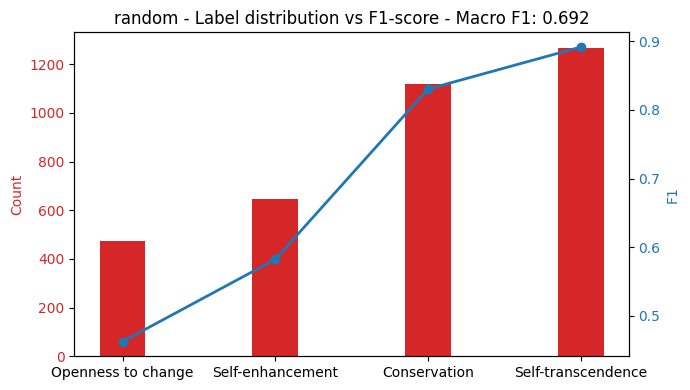

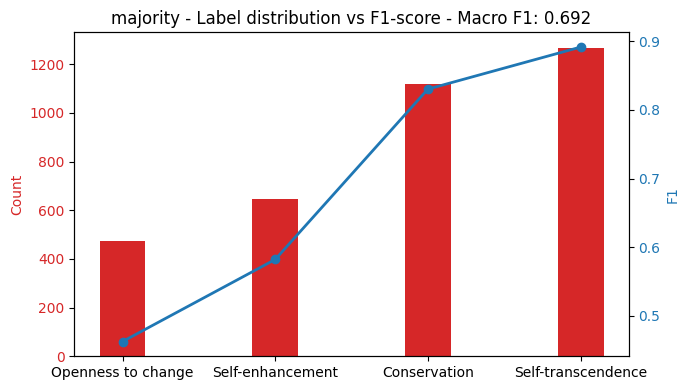

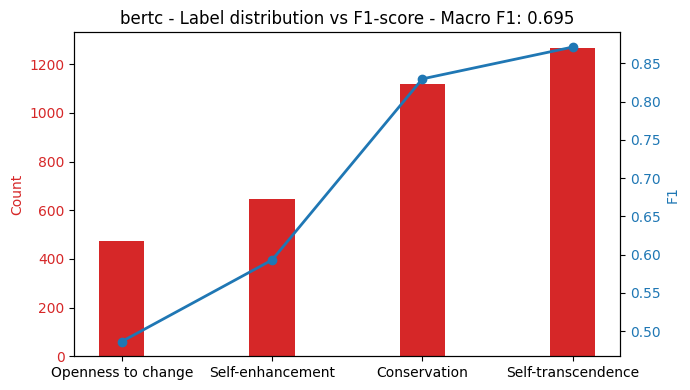

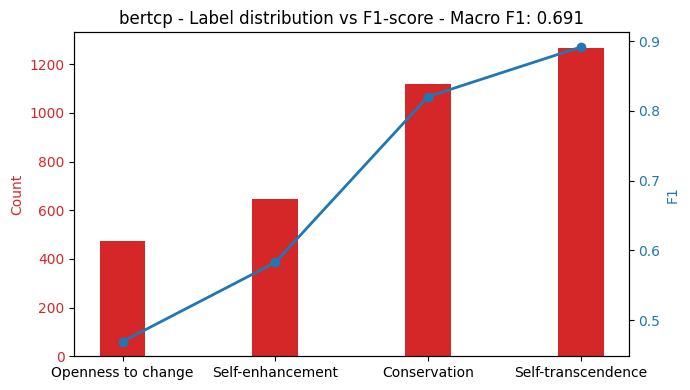

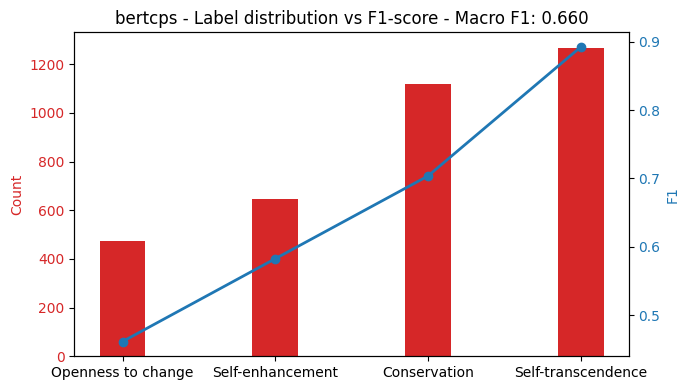

In [76]:
labels_count = test_dataset.labels.sum(axis=0)

for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.set_title(f'{model_name} - Label distribution vs F1-score - Macro F1: {model_results_best["macro_f1"]:.3f}')
    color = 'tab:red'
    ax1.bar(TOUCHE_VALUES, labels_count, color=color, width=0.3)
    ax1.set_xticklabels(TOUCHE_VALUES, rotation=0)
    ax1.set_ylabel('Count', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.plot(TOUCHE_VALUES, model_results_best['f1s'], color=color, linewidth=2, marker='o')
    ax2.set_ylabel('F1', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.show()


In [77]:
for model_name in list(results.keys()):
    print(f'{f"Comparison for model: {model_name}":_^65}')
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    model_summary = pd.DataFrame(index=TOUCHE_VALUES, columns=['Precision', 'Recall', 'F1'])
    for i, value_name in enumerate(TOUCHE_VALUES):
        model_summary.loc[value_name] = [
            round(precision_score(test_dataset.labels[:, i], model_results_best['all_outputs'][:, i] >= 0.5), 3),
            round(recall_score(test_dataset.labels[:, i], model_results_best['all_outputs'][:, i] >= 0.5), 3),
            round(model_results_best['f1s'][i],3)
        ]
    print(model_summary.head())
    print()

__________________Comparison for model: random___________________
                   Precision Recall     F1
Openness to change     0.301    1.0  0.462
Self-enhancement       0.411    1.0  0.582
Conservation            0.71    1.0   0.83
Self-transcendence     0.805    1.0  0.892

_________________Comparison for model: majority__________________
                   Precision Recall     F1
Openness to change     0.301    1.0  0.462
Self-enhancement       0.411    1.0  0.582
Conservation            0.71    1.0   0.83
Self-transcendence     0.805    1.0  0.892

___________________Comparison for model: bertc___________________
                   Precision Recall     F1
Openness to change     0.339  0.859  0.487
Self-enhancement       0.441  0.906  0.593
Conservation            0.71  0.997   0.83
Self-transcendence     0.806  0.948  0.871

__________________Comparison for model: bertcp___________________
                   Precision Recall     F1
Openness to change     0.308  0.981  0.469
Se

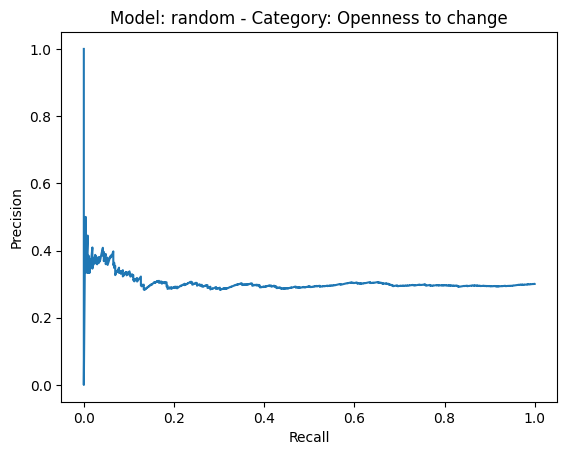

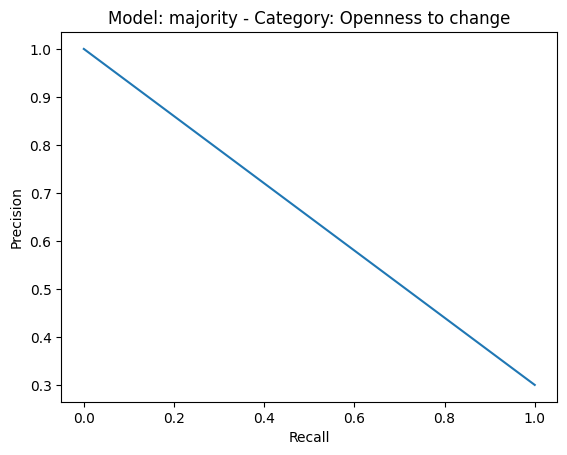

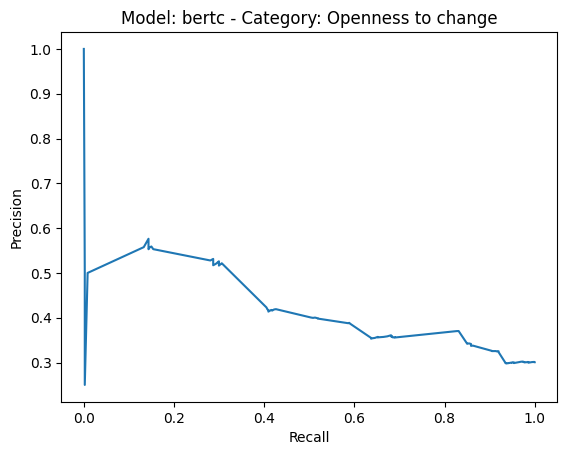

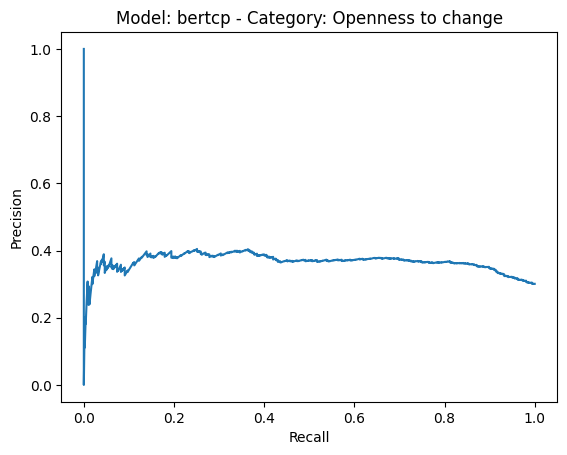

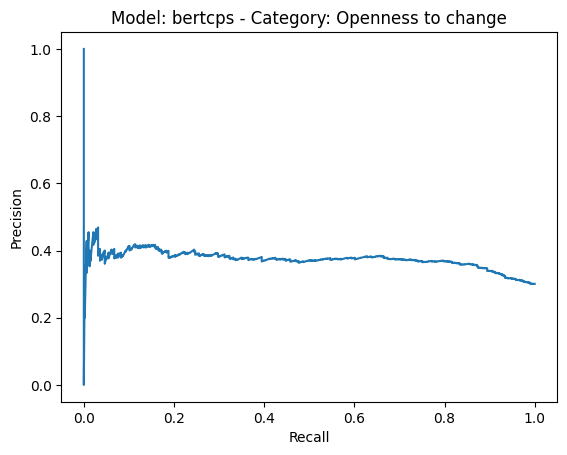

In [78]:
# computing precision-recall curve for each model on category with the lowest f1-score
for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    most_misclassified_category_index = np.argmin(model_results_best['f1s'])
    most_misclassified_category = TOUCHE_VALUES[most_misclassified_category_index]
    precision, recall, _ = precision_recall_curve(model_results_best['all_labels'][:, most_misclassified_category_index], model_results_best['all_outputs'][:, most_misclassified_category_index])
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Model: {model_name} - Category: {most_misclassified_category}')
    plt.show()

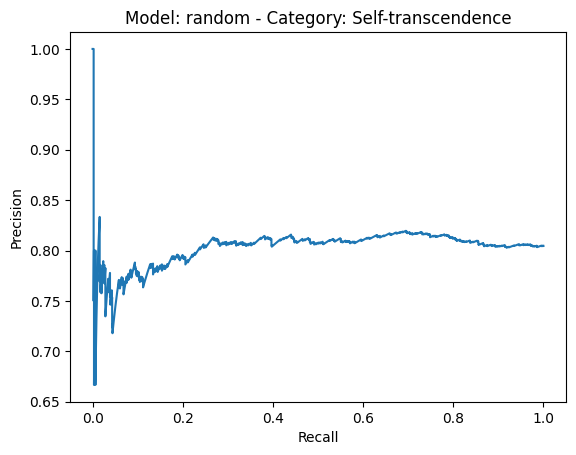

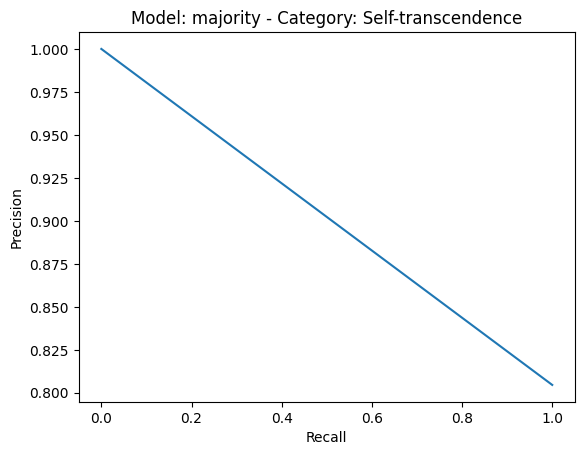

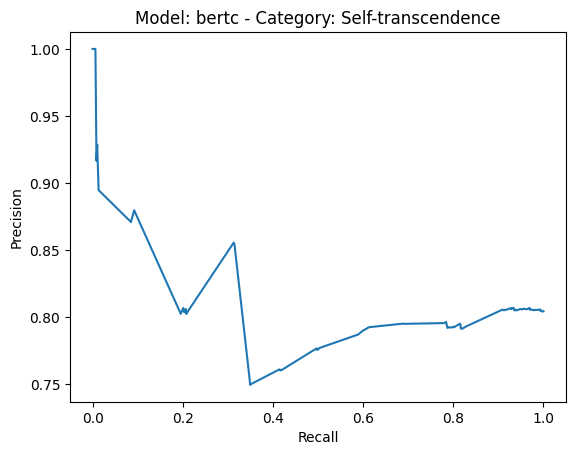

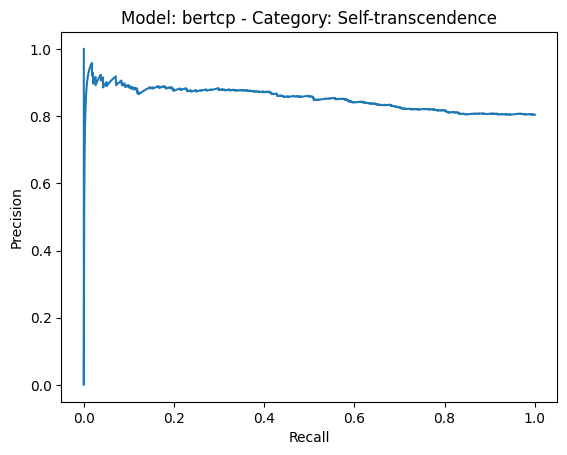

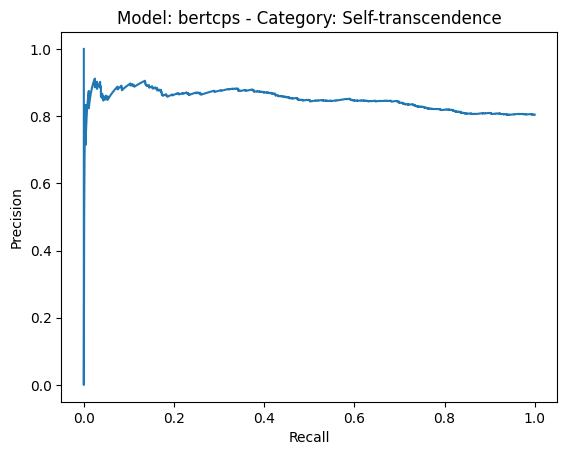

In [79]:
# computing precision-recall curve for each model on category with the highest f1-score
for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    most_classified_category_index = np.argmax(model_results_best['f1s'])
    most_classified_category = TOUCHE_VALUES[most_classified_category_index]
    precision, recall, _ = precision_recall_curve(model_results_best['all_labels'][:, most_classified_category_index], model_results_best['all_outputs'][:, most_classified_category_index])
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Model: {model_name} - Category: {most_classified_category}')
    plt.show()

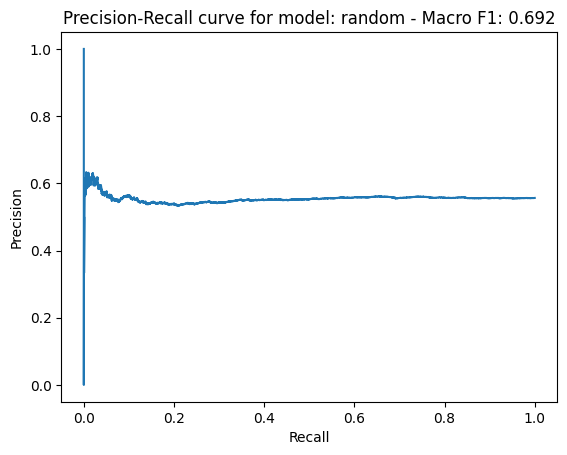

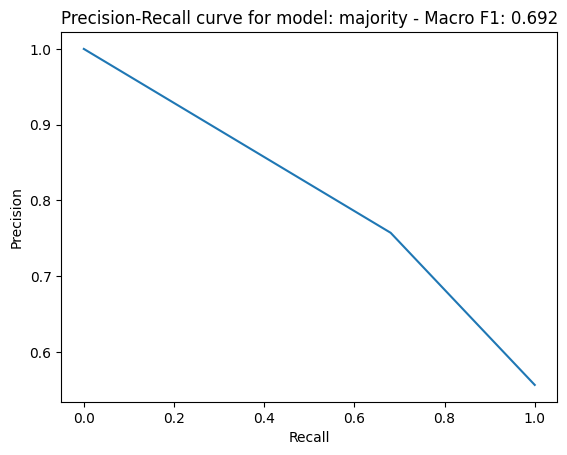

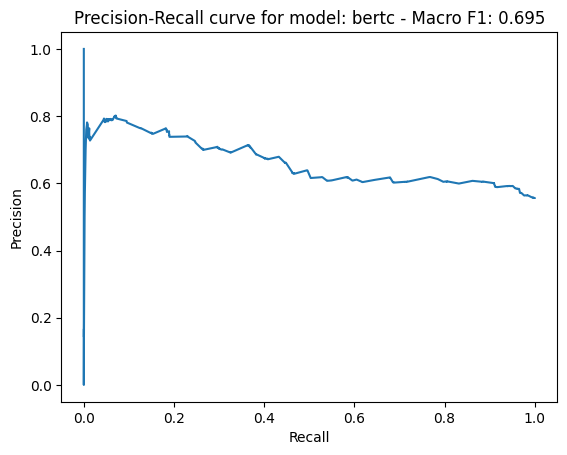

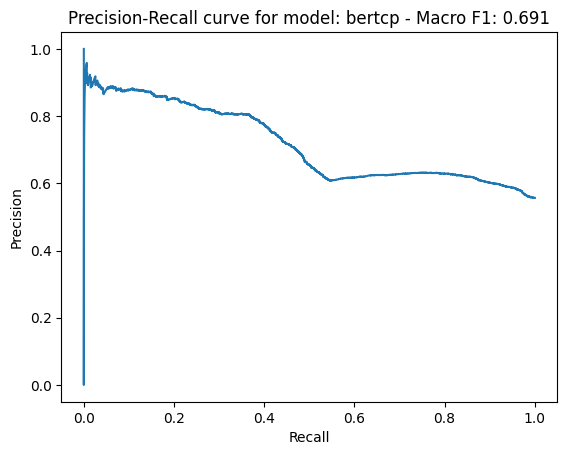

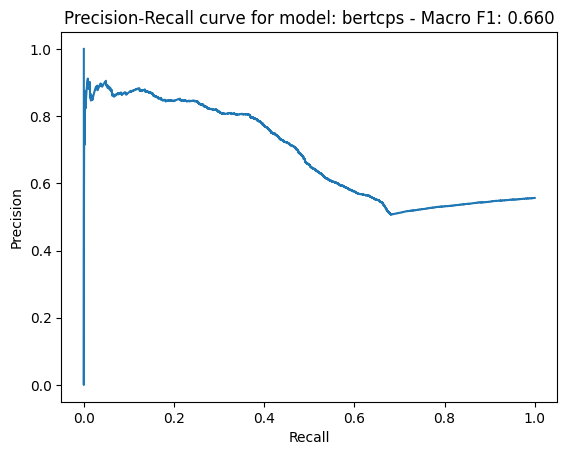

In [80]:
# computing precision-recall curve for each model on the macro f1 score
for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    precision, recall, _ = precision_recall_curve(model_results_best['all_labels'].flatten(), model_results_best['all_outputs'].flatten())
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for model: {model_name} - Macro F1: {model_results_best["macro_f1"]:.3f}')
    plt.show()

# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End